In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
import xgboost
import shap

In [2]:
data = pd.read_csv('listings_summary.csv')

In [3]:
# Print columns
data.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules',
       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms',

In [6]:
data.price+2

AttributeError: 'DataFrame' object has no attribute 'price_2'

In [41]:
# Cast price as float
data.price = data.price.apply(lambda x: x.replace("$", ""))
data.price = data.price.apply(lambda x: x.replace(",", ""))
data.price = data.price.astype("float")
data.price.describe()

count    22552.000000
mean        67.143668
std        220.266210
min          0.000000
25%         30.000000
50%         45.000000
75%         70.000000
max       9000.000000
Name: price, dtype: float64

In [42]:
# Get rid of outliers
print("99.5% properties have a price lower than {0: .2f}".format(np.percentile(data.price, 99.5)))
data = data[(data.price <= np.percentile(data.price, 99.5)) & (data.price > 0)]

99.5% properties have a price lower than  400.00


In [70]:
# Our first linear model
model = smf.ols('price ~ host_is_superhost + bedrooms', data=data).fit()

# Inspect the results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.259
Model:                            OLS   Adj. R-squared:                  0.259
Method:                 Least Squares   F-statistic:                     1583.
Date:                Sat, 25 Apr 2020   Prob (F-statistic):               0.00
Time:                        13:07:56   Log-Likelihood:                -90209.
No. Observations:               18087   AIC:                         1.804e+05
Df Residuals:                   18082   BIC:                         1.805e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [69]:
data.replace({'host_is_superhost' : {'t' : True, 'f' : False}}, inplace=True)

# Our first linear model
model = smf.ols('price ~ host_is_superhost + bedrooms', data=data).fit()

# Inspect the results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.227
Model:                            OLS   Adj. R-squared:                  0.227
Method:                 Least Squares   F-statistic:                     3288.
Date:                Sat, 25 Apr 2020   Prob (F-statistic):               0.00
Time:                        13:07:07   Log-Likelihood:            -1.1271e+05
No. Observations:               22398   AIC:                         2.254e+05
Df Residuals:                   22395   BIC:                         2.255e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

How often we get a coefficient which is as, or more extreme as the one we got?
0.05248484760238116


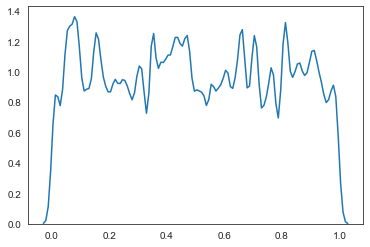

In [57]:
# Checking p-values meaning
N = 1000
x = np.zeros(N)
for i in range(N):
    df = pd.DataFrame({'x' : np.random.normal(size=30), 'y' : np.random.normal(size=30)})
    model = smf.ols('y ~ x', data=df).fit()
    x[i] = model.pvalues.x
sns.set_style('white')
sns.kdeplot(x, bw=0.01)
print('How often we get a coefficient which is as, or more extreme as the one we got?')
print(np.percentile(x, 5))

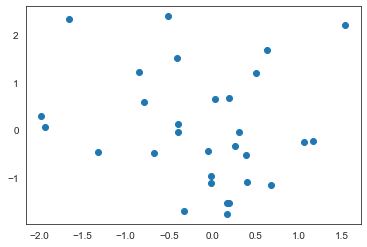

In [54]:
plt.scatter(np.random.normal(size=30), np.random.normal(size=30))

0.9582790091264668


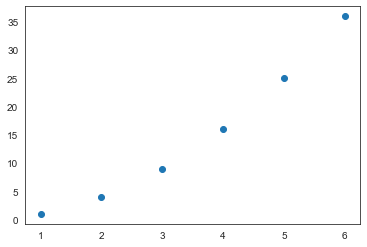

In [58]:
# Checking R^2 meaning
df = pd.DataFrame({'x' : [1,2,3,4,5,6], 'y' : [1,4,9,16,25,36]})
model = smf.ols('y ~ x', data=df).fit()
print(model.rsquared)
plt.scatter(x=df.x, y=df.y)

In [59]:
def rsquared(y_true, y_theo):
    y_true = np.array(y_true)
    y_theo = np.array(y_theo)
    return sum((y_theo-y_true.mean())**2)/sum((y_true-y_true.mean())**2)

In [11]:
df = pd.DataFrame({'x' : [1,2,3,4,5,6], 'y' : [1,4,9,16,25,36]})
df['x2'] = df.x**2
model = smf.ols('y ~ x + x2', data=df).fit()
model.rsquared

1.0

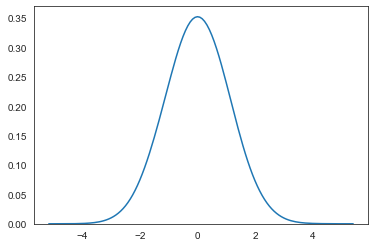

In [12]:
sns.kdeplot(np.random.normal(size=10000), bw=0.5)

(0.0006310139544582999,
 33.97597737002377,
 -0.5271609735856452,
 11.070380445298548)

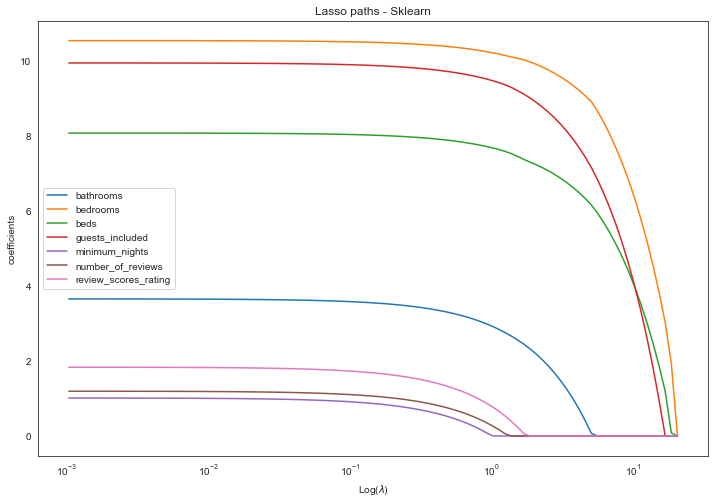

In [71]:
# Lasso 

variables = ['bathrooms', 'bedrooms', 'beds', 'guests_included', 'minimum_nights', 'number_of_reviews', 'review_scores_rating']

data_subset = data.loc[:, variables + ['price']]
data_subset.dropna(inplace=True)

X = data_subset.loc[:,variables]
X = preprocessing.scale(X)
y = np.array(data_subset.price)

alphas_lasso, coefs_lasso, _ = linear_model.lasso_path(X, y, 5e-5, fit_intercept=False)

# Display results
plt.figure(figsize = (12,8))

for i in range(X.shape[1]):
    plt.plot(alphas_lasso, coefs_lasso[i], label = variables[i])

plt.xscale('log')
plt.xlabel('Log($\\lambda$)')
plt.ylabel('coefficients')
plt.title('Lasso paths - Sklearn')
plt.legend()
plt.axis('tight')

In [78]:
# XGBoost

variables = ['bathrooms', 'bedrooms', 'beds', 'guests_included', 'minimum_nights', 'number_of_reviews', 'review_scores_rating']

data_subset = data.loc[:, variables + ['price']]
data_subset.dropna(inplace=True)
data_subset = data_subset.iloc[:1000,:]

X = data_subset.loc[:,variables]
#X = preprocessing.scale(X) #We don't have to scale it as trees don't care about distributions, means, and all that
y = np.array(data_subset.price)

model = xgboost.XGBRegressor(n_estimators=10)
model.fit(X, y)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=10, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

In [75]:
predicted = model.predict(X)
mean_squared_error(y, predicted)
#What does it even mean? Todo: check different error functions and how they can be explained
#Did we do a proper training and prediction? NO - we need to have proper TRAIN and TEST sets! Todo at home ;)

22.0932879546265

In [79]:
#Playing with Shapley values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [80]:
X.iloc[0,:]

bathrooms                 1.0
bedrooms                  1.0
beds                      2.0
guests_included           1.0
minimum_nights            4.0
number_of_reviews       118.0
review_scores_rating     93.0
Name: 0, dtype: float64

In [81]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

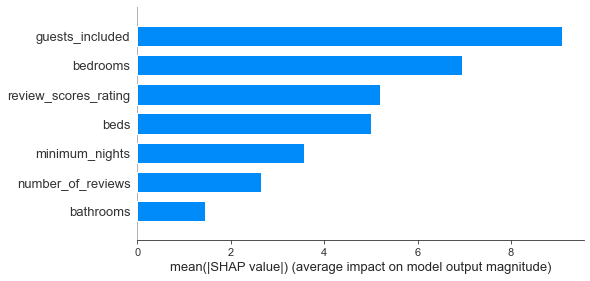

In [21]:
shap.summary_plot(shap_values, X, plot_type="bar")

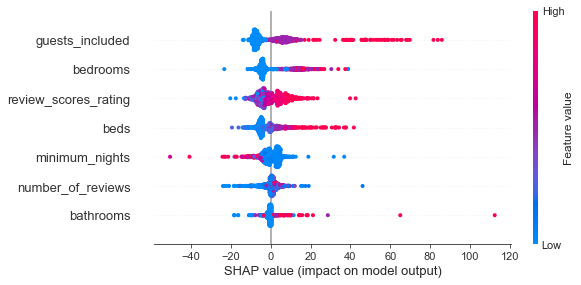

In [22]:
shap.summary_plot(shap_values, features=X, feature_names=X.columns)

In [ ]:
#Sources:
#https://www.kaggle.com/yaowenling/berlin-airbnb-data-exploration-public
#https://xavierbourretsicotte.github.io/lasso_implementation.html